In [1]:
import numpy as np
import pandas as pd
import cv2
import joblib
import time
import torchvision.transforms as transforms
from generate_perturbation import extract_image_attributes, tensor_to_image, get_features

#libraries for yolo
import torch
from pytorchyolo.models import load_model
from pytorchyolo.utils.utils import non_max_suppression
from pytorchyolo.utils.transforms import Resize, DEFAULT_TRANSFORMS

In [2]:
path = r"E:\Documents\GitHub\THS-ST1\images\test\girl.jpg"
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = transforms.Compose([DEFAULT_TRANSFORMS,Resize(416)])((image, np.zeros((1, 5))))[0].unsqueeze(0) # 

In [3]:
device, model = load_model('./weights/yolo_face_sthanhng.cfg', "./weights/yolo_face_sthanhng.weights")
model.eval()

model.gradient_mode = False
for yolo_layer in model.yolo_layers:
    yolo_layer.gradient_mode = False

In [4]:
with torch.no_grad():
    # Forward pass the data through the model and call non max suppression
    nms, nms_output = non_max_suppression(model(image), 0.5, 0.5) #conf_thres and iou_thres = 0.5

In [5]:
nms_output

[tensor([[207.2131, 239.4359, 161.9002, 219.8698,   1.0000,   1.0000]])]

In [6]:
model = joblib.load("models/mpr_tunedfs_bo_LAB_bbox_e_face_yf.pkl")

In [7]:
n = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

time_list = []
for times in n:
    print("N", times)
    timeStart = time.time() #time started
    
    for i in range(times):
        row = {}
        x, y, w, h = 207, 239, 161, 219
        row['x'], row['y'], row['w'], row['h'] = x, y, w, h

        x1 = max(int(np.floor((x - w / 2))), 0)
        y1 = max(int(np.floor((y - h / 2))), 0)
        x2 = min(int(np.ceil((x + w / 2))), 415)
        y2 = min(int(np.ceil((y + h / 2))), 415)

        cropped_image = image[:, :, y1:y2, x1:x2] #get the first dimension, the channels, and crop it
        cropped_image = tensor_to_image(cropped_image) #reshape the image to (w/h, h/w, channel)

        row = extract_image_attributes(row, path, 0, cropped_image, "bbox")

        row = [row]
        df = pd.DataFrame.from_dict(row)
        predict_features = get_features("LAB", "bbox")
        X_features = df.loc[:,  predict_features]
        output = model.predict(X_features)
    
    timeEnd = time.time()
    timeTotal = timeEnd - timeStart
    
    time_list.append(timeTotal)
    print("Time", timeTotal)
    

N 4
Time 0.23321270942687988
N 8
Time 0.2151954174041748
N 16
Time 0.4324018955230713
N 32
Time 0.8474559783935547
N 64
Time 1.6973741054534912
N 128
Time 3.3851399421691895
N 256
Time 6.843582391738892
N 512
Time 13.506032466888428
N 1024
Time 26.95420265197754
N 2048
Time 54.020124197006226
N 4096
Time 109.4421854019165
N 8192
Time 221.27109932899475


In [8]:
x, y, w, h = 207, 239, 161, 219

x1 = max(int(np.floor((x - w / 2))), 0)
y1 = max(int(np.floor((y - h / 2))), 0)
x2 = min(int(np.ceil((x + w / 2))), 415)
y2 = min(int(np.ceil((y + h / 2))), 415)

In [10]:
mask = np.zeros(image.shape)
mask[..., y1:y2, x1:x2] = 1

In [12]:
from minepsilon import binary_search, yf_det_fn

face_detection_yunet_2022mar.onnx:: status : file already exists


In [13]:
binary_search(0, 3, image, image, yf_det_fn, mask, (x1, y1, x2, y2))

0.8709570312500001

In [15]:
bin_time_list = []
for times in n:
    print("N", times)
    timeStart = time.time() #time started
    
    for i in range(times):
        binary_search(0, 3, image, image, yf_det_fn, mask, (x1, y1, x2, y2))
    timeEnd = time.time()
    timeTotal = timeEnd - timeStart
    
    bin_time_list.append(timeTotal)
    print("Time", timeTotal)

N 4
Time 17.483110189437866
N 8
Time 35.325663805007935
N 16
Time 70.07967567443848
N 32
Time 141.69139075279236
N 64
Time 285.2648060321808
N 128
Time 590.7803544998169
N 256


KeyboardInterrupt: 

In [32]:
bin_time_list = [17.483110189437866,
 35.325663805007935,
 70.07967567443848,
 141.69139075279236,
 285.2648060321808,
 590.7803544998169]

In [33]:
calculate_list = bin_time_list
for i in range(6, len(time_list)):
    factor = time_list[i] / time_list[i - 1]
    calculate_list.append(calculate_list[i - 1] * factor)

In [37]:
calculate_list[:8]

[17.483110189437866,
 35.325663805007935,
 70.07967567443848,
 141.69139075279236,
 285.2648060321808,
 590.7803544998169,
 1194.3535867085684,
 2357.0956548287913]

In [36]:
time_list[:8]

[0.23321270942687988,
 0.2151954174041748,
 0.4324018955230713,
 0.8474559783935547,
 1.6973741054534912,
 3.3851399421691895,
 6.843582391738892,
 13.506032466888428]

In [40]:
import matplotlib.pyplot as plt

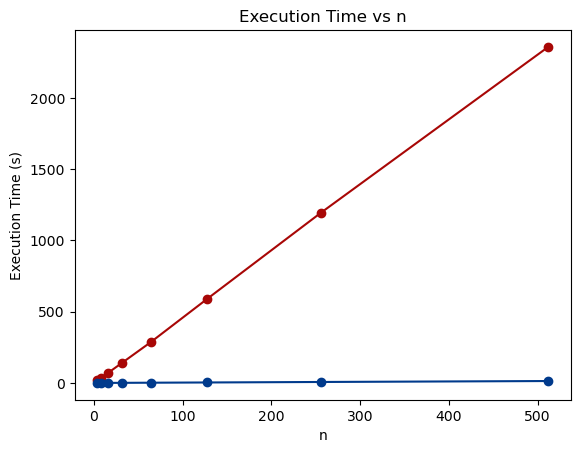

In [44]:
plt.title('Execution Time vs n')
plt.xlabel("n")
plt.ylabel("Execution Time (s)")
plt.plot(n[:8], calculate_list[:8], marker='o', color="#A80706")
plt.plot(n[:8], time_list[:8], marker='o', color="#003A8C")
plt.show()